In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re

%matplotlib inline

clear_output()

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 500

In [3]:
molstr_list = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
    'HeHe',
    'HeLi+',
    'HeBe',
    'LiLi',
    'LiBe+',
    'BeBe',
]

In [4]:
inp_grp = []
for molstr in molstr_list:
    if '+' in molstr:
        charge = 1
    elif '-' in molstr:
        charge = -1
    else:
        charge = 0
    alist = re.findall('[A-Z][a-z]*', molstr)
    Zs = [qtk.n2Z(a) for a in alist]
    inp_list = []
    inp_grp.append(inp_list)
    res = resolution
    for R in np.arange(0.3, 4.0 + res, res):
        mol = qtk.Molecule()
        ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
        mol.build(ZR)
        mol.charge = charge
        mol.name = mol.name + '_%s' % str(R)
        inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
        try:
            inp.run()
            D, U = np.linalg.eig(inp.olp)
            inp.X = U / np.sqrt(D)
            inp_list.append(inp)
        except:
            pass
    print "%s finished" % mol.name
print [len(inp) for inp in inp_grp]

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
He2_4.0 finished
He1Li1_4.0 finished
He1Be1_4.0 finished
Li2_4.0 finished
Li1Be1_4.0 finished
Be2_4.0 finished
[741, 741, 741, 563, 741, 741, 741, 741, 741, 741]


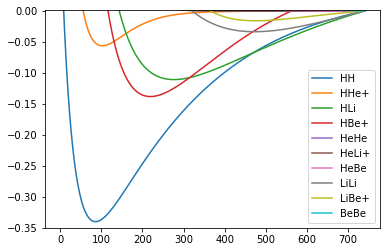

In [5]:
for i in range(len(inp_grp)):
    inp = inp_grp[i]
    E = np.array([o.Et for o in inp])
    E = E-E[-1]
    #print E
    plt.plot(E, label=molstr_list[i])
plt.ylim(-0.35, 0.001)
plt.legend()

In [6]:
from sklearn.model_selection import train_test_split

def train_test_valid(valid_ind):
    if valid_ind >= len(inp_grp):
        valid_ind = len(inp_grp) - 1
    print "%s is used as validation molecule" % molstr_list[valid_ind]
    inp_valid = inp_grp[valid_ind]
    if valid_ind > 0:
        inps_all = list(qtk.flatten([inp_grp[i] for i in range(len(inp_grp)) if i != valid_ind]))
    else:
        inps_all = list(qtk.flatten(inp_grp))
    inp_train, inp_test = train_test_split(inps_all, random_state=0, test_size=0.1)
    return inp_train, inp_test, inp_valid
    
inp_train, inp_test, inp_valid = train_test_valid(2)

HLi is used as validation molecule


In [7]:
# Numpy version implementation

def get_input_tensor(mol):
    """Extract matrices and pack as tensor"""
    S, K, Na, C0, X, Er = mol.olp, mol.kin, mol.na, mol.initial_mov, mol.X, mol.er
    I = np.stack([S, K, Na, C0, X])
    nn = mol.ht_external['nn']
    occ = mol.ht_exp_alpha.occupations
    return I, Er, occ, nn
    
def get_output(I, Er, occ, nn, C):
    """take input tensor and approximated MO coefficients, C, to compute total energy"""
    K = I[1]
    Na = I[2]
    dm = (C * occ).dot(C.T)
    
    Ek = np.trace(dm.dot(K)) * 2
    Ev = np.trace(dm.dot(Na)) * 2
    Ej = np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,2])))) * 2
    Ex = -np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,1]))))
    E_tot = np.sum([Ek, Ev, Ej, Ex, nn])
    return E_tot

inp = inp_grp[1][0]
I_np, Er_np, occ, nn = get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
get_output(I_np, Er_np, occ, nn, C)

-2.0469888703850661

In [8]:
def tfIO(mol_list):
    I_list, Er_list, occ_list, nn_list, C_list, labels = [[] for _ in range(6)]
    for mol in mol_list:
        C = mol.ht_exp_alpha.coeffs.__array__()
        C_list.append(C)
        I, Er, occ, nn = get_input_tensor(mol)
        I_list.append(I)
        Er_list.append(Er)
        occ_list.append(occ)
        nn_list.append(nn)
        labels.append(get_output(I, Er, occ, nn, C))
        
    return np.stack(I_list).astype(np.float64), np.stack(Er_list).astype(np.float64), \
           np.stack(occ_list).astype(np.float64), np.stack(nn_list).astype(np.float64), \
           np.stack(C_list).astype(np.float64), np.stack(labels).astype(np.float64)

def tfIO_batch(mol_list, batch_size):
    
    def batches(mol_list):
        for i in range(0, len(mol_list), batch_size):
            yield mol_list[i:i + batch_size]

    I, Er, occ, nn, C, y = [], [], [], [], [], []
    for mol_batch in batches(mol_list):
        I_b, Er_b, occ_b, nn_b, C_b, y_b = tfIO(mol_batch)
        I.append(I_b)
        Er.append(Er_b)
        occ.append(occ_b)
        nn.append(nn_b)
        C.append(C_b)
        y.append(y_b)
    return I, Er, occ, nn, C, y

I_train, Er_train, occ_train, nn_train, C_train, y_train = tfIO_batch(inp_train, batch_size)
I_test, Er_test, occ_test, nn_test, C_test, y_test = tfIO_batch(inp_test, batch_size)
I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = tfIO_batch(inp_valid, batch_size)

In [9]:
I_test[0].shape

(500, 5, 4, 4)

In [ ]:
import tensorflow as tf

def hidden_layer(I, C_prd = None, sess=None):
    
    if C_prd is None:
        #C_prd = I[-2]
        C_prd = I[:,-2]
        
    shape = C_prd.shape[-2:]
    S, K, V = I[:,0], I[:,1], I[:,2]
    
    Wc = tf.Variable(tf.truncated_normal(shape, dtype=tf.float64), name='weights_C', dtype=tf.float64)
    Bc = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='biases_C', dtype=tf.float64)
    Ws = tf.Variable(tf.truncated_normal(shape, dtype=tf.float64), name='weights_S', dtype=tf.float64)
    Bs = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='biases_S', dtype=tf.float64)
    Wk = tf.Variable(tf.truncated_normal(shape, dtype=tf.float64), name='weights_K', dtype=tf.float64)
    Bk = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='biases_K', dtype=tf.float64)
    Wv = tf.Variable(tf.truncated_normal(shape, dtype=tf.float64), name='weights_V', dtype=tf.float64)
    Bv = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='biases_V', dtype=tf.float64)
    
    if sess:
        sess.run(tf.global_variables_initializer())
    
    C_new = tf.add(tf.scan(lambda a, x: tf.matmul(x, Wc), C_prd), Bc)
    S_new = tf.add(tf.scan(lambda a, x: tf.matmul(x, Ws), S), Bs)
    K_new = tf.add(tf.scan(lambda a, x: tf.matmul(x, Wk), K), Bk)
    V_new = tf.add(tf.scan(lambda a, x: tf.matmul(x, Wv), V), Bv)
    
    new_matrix = tf.add(tf.add(tf.add(C_new, S_new), K_new), V_new)
    
    #return tf.nn.relu(new_matrix)
    return tf.nn.dropout(new_matrix, 0.8)

def hamiltonian_layer(I, C_prd = None, sess = None):
    
    if C_prd is None:
        #C_prd = I[-2]
        C_prd = I[:,-2]
        
    shape = C_prd.shape[-2:]
    S, K, V = I[:,0], I[:,1], I[:,2]
    
    Wc = tf.Variable(tf.truncated_normal(shape, dtype=tf.float64), name='weights_C', dtype=tf.float64)
    Bc = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='biases_C', dtype=tf.float64)
    
    if sess:
        sess.run(tf.global_variables_initializer())
    
    C_new = tf.add(tf.scan(lambda a, x: tf.matmul(x, Wc), C_prd), Bc)
    
    H_one = tf.add(tf.add(S, K), V)
    HC = tf.matmul(H_one, C_new)
    CT = tf.transpose(C_new, perm=[0,2,1])
    H_new = tf.matmul(CT, HC)
    
    _, C_prd = tf.self_adjoint_eig(H_new)
    
    return tf.matmul(I[:, -1], C_prd)

def normailization_layer(I, C_prd=None):
    
    if C_prd is None:
        #C_prd = I[-2]
        C_prd = I[:,-2]
        
    shape = C_prd.shape[-2:]
        
    W = tf.Variable(tf.truncated_normal(shape, dtype=tf.float64), name='weights', dtype=tf.float64)
    B = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='biases', dtype=tf.float64)
    
    C_new = tf.add(tf.scan(lambda a, x: tf.matmul(x, W), C_prd), B)
    
    C_sym = tf.matmul(tf.transpose(C_new, perm=[0,2,1]), C_new)
    _, C_diag = tf.self_adjoint_eig(C_sym)
    
    return tf.matmul(I[:,-1], C_diag)

def output_layer(I, Er, occ, nn, C_prd, sess=None):
    K, Na = I[:,1], I[:,2]
    
    batch = tf.shape(I)[0]
    C_occ = tf.multiply(tf.expand_dims(occ, 1), C_prd)
    #C_occ = tf.matmul(tf.expand_dims(0, occ), C)
    dm = tf.matmul(C_occ, tf.transpose(C_prd, perm=[0,2,1]))
    
    ind = tf.transpose(tf.stack([tf.range(batch), tf.range(batch)]))
    J_kernel = tf.gather_nd(tf.tensordot(dm, Er, axes=([1,2], [1,3])), ind)
    X_kernel = tf.gather_nd(tf.tensordot(dm, Er, axes=([1,2], [1,2])), ind)
    
    Ek = tf.trace(tf.matmul(dm, K)) * 2
    Ev = tf.trace(tf.matmul(dm, Na)) * 2
    Ej = tf.trace(tf.matmul(dm, J_kernel)) * 2
    Ex = -tf.trace(tf.matmul(dm, X_kernel))
    
    E_total = tf.add(Ek, Ev)
    E_total = tf.add(E_total, Ej)
    E_total = tf.add(E_total, Ex)
    E_total = tf.add(E_total, nn)
    
    return E_total
    

# test
_N = 20
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    E = output_layer(I_test[0], Er_test[0], occ_test[0], nn_test[0], C_test[0], sess)
    C_orth = normailization_layer(I_test[0])
    print sess.run(E) -y_test[0]

[  1.77635684e-15   8.88178420e-16   0.00000000e+00  -5.32907052e-15
   0.00000000e+00   0.00000000e+00  -3.55271368e-15  -2.22044605e-16
  -7.10542736e-15   0.00000000e+00   0.00000000e+00  -2.13162821e-14
   1.42108547e-14  -7.10542736e-15   3.55271368e-15   0.00000000e+00
   0.00000000e+00  -1.42108547e-14   0.00000000e+00   0.00000000e+00
  -2.66453526e-15   0.00000000e+00   3.55271368e-15   1.77635684e-15
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -3.55271368e-15
   0.00000000e+00   0.00000000e+00  -1.42108547e-14   0.00000000e+00
   0.00000000e+00  -7.10542736e-15   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -1.42108547e-14   0.00000000e+00   0.00000000e+00
  -1.42108547e-14   5.32907052e-15   0.00000000e+00   0.00000000e+00
   5.32907052e-15  -7.10542736e-15   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.55271368e-15
   0.00000000e+00   7.10542736e-15

In [ ]:
tf.reset_default_graph()

def get_shape(tensor):
    shape = list(tensor.shape)
    shape.insert(0, None)
    return shape

# input tensors
I = tf.placeholder(tf.float64, shape=get_shape(I_test[0][0]), name='I')
Er = tf.placeholder(tf.float64, shape=get_shape(Er_test[0][0]), name='Er')
occ = tf.placeholder(tf.float64, shape=get_shape(occ_test[0][0]), name='occ')
nn = tf.placeholder(tf.float64, shape=get_shape(nn_test[0][0]), name='nn')

# training tensors
C_ref = tf.placeholder(tf.float64, shape=get_shape(C_test[0][0]), name='C_ref')
y = tf.placeholder(tf.float64, shape=get_shape(y_test[0][0]), name='y')

# network architecture
C_prd = hidden_layer(I)
C_prd = hamiltonian_layer(I, C_prd)
for _ in range(5):
    C_prd = hamiltonian_layer(I, C_prd)
C_prd = hidden_layer(I, C_prd)
for _ in range(5):
    C_prd = hamiltonian_layer(I, C_prd)
C_prd = hidden_layer(I, C_prd)
C_prd = hamiltonian_layer(I, C_prd)
C_prd = normailization_layer(I, C_prd)
C_prd = normailization_layer(I, C_prd)
y_prd = output_layer(I, Er, occ, nn, C_prd)

err = tf.pow(y - y_prd, 2)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(err)
optimizer = tf.train.AdamOptimizer(0.03).minimize(err) # default learning rate 0.001

err_list = []
err_list_test = []
itr_list = []
E_prd_list = []
C_prd_list = []

# add C_prd_iteration history for post processing on the learning of the following properties
# 1. density difference
# 2. force
# 3. dipole moment
# 4. HOMO-LUMO gap

saver = tf.train.Saver()
save_path = "H2-500_E-5_test.ckpt"

#with tf.Session() as sess:
sess = tf.Session()
try:
    train_err_hist = []
    test_err_hist = []
    valid_err_hist = []
    C_valid_hist = []
    
    err_list = []
    err_list_valid = []
    itr_list = []
    E_prd_list = []
    C_prd_list = []
    C_hist = []
    
    try:
        saver.restore(sess, save_path)
        msg = 'model loaded, continue optimizing'
        C_hist = qtk.load('history.pkl')
    except:
        sess.run(tf.global_variables_initializer())
        msg = 'no model found, start from scratch'

    print msg
    test_err = 1
    epoch = 0 # i.e. epoch
    while test_err > 0.00001:
    #for opt_itr in range(200):
    
        train_err_list = []
        for I_b, Er_b, occ_b, nn_b, C_b, y_b in zip(I_train, Er_train, occ_train, nn_train, C_train, y_train):
            train_dict = {I:I_b, Er:Er_b, occ:occ_b, nn:nn_b, y:y_b}
            sess.run(optimizer, feed_dict=train_dict)
            train_err_list.append(np.array(sess.run(err, feed_dict=train_dict)))
        train_err = np.concatenate(train_err_list).mean()
        train_err_hist.append(train_err)
        
        test_err_list = []
        for I_t, Er_t, occ_t, nn_t, C_t, y_t in zip(I_test, Er_test, occ_test, nn_test, C_test, y_test):
            test_dict = {I:I_t, Er:Er_t, occ:occ_t, nn:nn_t, y:y_t}
            test_err_list.append(np.array(sess.run(err, feed_dict=test_dict)))
        test_err = np.concatenate(test_err_list).mean()
        test_err_hist.append(test_err)
        
        valid_err_list = []
        for I_v, Er_v, occ_v, nn_v, C_v, y_v in zip(I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid):
            valid_dict = {I:I_v, Er:Er_v, occ:occ_v, nn:nn_v, y:y_v}
            valid_err_list.append(np.array(sess.run(err, feed_dict=valid_dict)))
        valid_err = np.concatenate(valid_err_list).mean()
        valid_err_hist.append(valid_err)
            
        print "epoch: %5d train/test/validatoin error: %f/%f/%f" % (epoch, train_err, test_err, valid_err)
        epoch += 1
        
#     save_path_out = saver.save(sess, save_path)
#     print("Model saved in file: %s" % save_path_out)
#     qtk.save(C_hist, 'history.pkl')
    
except KeyboardInterrupt:
    print "keyboard interrupt"
#     save_path_out = saver.save(sess, save_path)
#     print("Model saved in file: %s" % save_path_out)
#     sess.close()
#     qtk.save(C_hist, 'history.pkl')

INFO:tensorflow:Restoring parameters from H2-500_E-5_test.ckpt
no model found, start from scratch
epoch:     0 train/test/validatoin error: 10.832525/8.956415/7.090950
epoch:     1 train/test/validatoin error: 8.610832/8.619044/5.606137
epoch:     2 train/test/validatoin error: 7.225446/6.206210/3.972801
epoch:     3 train/test/validatoin error: 4.962830/3.995367/3.832737
epoch:     4 train/test/validatoin error: 2.974480/2.718431/3.103490
epoch:     5 train/test/validatoin error: 1.836998/1.344567/2.133879
epoch:     6 train/test/validatoin error: 0.942917/0.760422/0.906133
epoch:     7 train/test/validatoin error: 0.546354/0.501667/0.573355
epoch:     8 train/test/validatoin error: 0.393111/0.504300/0.417580
epoch:     9 train/test/validatoin error: 0.329677/0.313792/0.488839
epoch:    10 train/test/validatoin error: 0.328807/0.321917/0.284070
epoch:    11 train/test/validatoin error: 0.271858/0.462750/0.304208
epoch:    12 train/test/validatoin error: 0.239143/0.283990/0.375979
epoc